## Importing Essential Libraries

This segment imports essential libraries needed for data processing and analysis:

- **pandas**: Used for handling and manipulating datasets.
- **numpy**: Used for numerical computations.
- **datetime**: Used for handling date and time data.
- **scipy**: Used for statistical operations.
- **matplotlib**: Used for visualizing data.

In [224]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns



## Loading Datasets

Here, the datasets are loaded using `pd.read_csv()`. This function reads CSV files into Pandas DataFrames, making the data easier to work with. Loading the telemetry and vehicle data at this stage is critical for the subsequent preprocessing steps, where the data will be cleaned and combined.


In [225]:
# Load the datasets (replace with actual file paths or loading methods)
telemetry1 = pd.read_csv("C:/Users/ANSUMAN/Downloads/Assignment_fuel/Assignment_fuel/telemetry_1.csv")
telemetry2 = pd.read_csv("C:/Users/ANSUMAN/Downloads/Assignment_fuel/Assignment_fuel/telemetry_2.csv")
vehicle_data = pd.read_csv("C:/Users/ANSUMAN/Downloads/Assignment_fuel/Assignment_fuel/vehicle_data.csv")


## Converting Timestamps

This segment converts timestamp columns from strings to datetime objects using `pd.to_datetime()`. Converting timestamps ensures that the date and time information is consistent and comparable across records, which is vital for time-series analysis. The `errors='coerce'` parameter forces any errors (e.g., unconvertible strings) to be set as `NaT`, allowing for easier handling of problematic data.


In [226]:
# Handle timestamp conversion with mixed formats
telemetry1['timestamp'] = pd.to_datetime(telemetry1['timestamp'], format='mixed', errors='coerce')
telemetry2['timestamp'] = pd.to_datetime(telemetry2['timestamp'], format='mixed', errors='coerce')

# Verify that all timestamps were converted correctly
print(telemetry1['timestamp'].head())
print(telemetry2['timestamp'].head())

# Optional: Check if any timestamps couldn't be converted
print(telemetry1[telemetry1['timestamp'].isnull()])
print(telemetry2[telemetry2['timestamp'].isnull()])


C:\Users\ANSUMAN\AppData\Local\Temp\ipykernel_17448\1857170664.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  telemetry1['timestamp'] = pd.to_datetime(telemetry1['timestamp'], format='mixed', errors='coerce')


0           2024-06-06 14:26:23-07:00
1    2024-07-05 22:24:12.856000-07:00
2    2024-06-20 12:57:59.306000-07:00
3    2024-07-24 18:04:23.776000-07:00
4           2024-07-06 11:08:03-07:00
Name: timestamp, dtype: object
0          2024-07-23 19:56:44+05:30
1          2024-04-04 22:33:56+05:30
2   2024-07-18 23:30:04.027000+05:30
3   2024-05-22 00:49:49.402000+05:30
4   2024-07-16 05:48:11.710000+05:30
Name: timestamp, dtype: datetime64[ns, UTC+05:30]
Empty DataFrame
Columns: [vehicle_id, timestamp, speed, odometer, fuel_level]
Index: []
Empty DataFrame
Columns: [vehicle_id, timestamp, val, name]
Index: []


## Standardizing Column Names and Dropping Unnecessary Columns

Standardizing column names ensures consistency across datasets, making the data easier to work with and reducing the risk of errors during analysis. Dropping unnecessary columns like `speed_name` simplifies the dataset, focusing only on relevant data points. This is a good practice in data preprocessing to reduce complexity and improve the efficiency of subsequent analysis.


In [227]:
# Standardize column names for consistency
telemetry1.columns = ['vehicle_id', 'timestamp', 'speed', 'odometer', 'fuel_level']
telemetry2.columns = ['vehicle_id', 'timestamp', 'speed', 'speed_name']

# Drop unnecessary columns from telemetry2
telemetry2.drop(columns=['speed_name'], inplace=True)


# Data Merging and Sorting
Merging the datasets using pd.concat() allows for the integration of multiple telemetry sources, providing a more comprehensive dataset. Sorting the data by vehicle_id and timestamp ensures that the data is in chronological order, which is essential for accurate time-series analysis, such as calculating distances and fuel consumption over time.

In [228]:
# Check for missing values
# Merge telemetry datasets based on vehicle_id and timestamp
combined_telemetry = pd.concat([telemetry1, telemetry2], ignore_index=True)
combined_telemetry.sort_values(by=['vehicle_id', 'timestamp'], inplace=True)
missing_data = combined_telemetry.isnull().sum()
#Printing total missing values found in the dataset
print(missing_data)
print(combined_telemetry.head())


vehicle_id         0
timestamp          0
speed         137590
odometer      561997
fuel_level    738004
dtype: int64
       vehicle_id                  timestamp  speed  odometer  fuel_level
685156  vehicle_1  2024-01-02 20:50:03+05:30  466.0       NaN         NaN
97348   vehicle_1  2024-01-02 07:20:04-08:00    NaN       NaN       100.0
493341  vehicle_1  2024-01-02 20:50:22+05:30    0.0       NaN         NaN
56864   vehicle_1  2024-01-02 07:21:05-08:00    NaN     466.0         NaN
181519  vehicle_1  2024-01-02 07:21:06-08:00    NaN       NaN       100.0


## Handling Missing Data

To preprocess the vehicle telemetry data, several steps were taken to ensure data accuracy and completeness. Forward filling was applied to non-zero values in the speed, odometer, and fuel_level columns to maintain continuity and avoid propagating erroneous zero values. Interpolation was then used for these continuous variables to estimate missing data points, ensuring a smooth and consistent dataset.

A speed threshold was established by identifying the most common speed modes, with values exceeding 150 mph clipped to this threshold to eliminate unrealistic speed data. This step ensures that the speed data remains within a reasonable range and prevents distortion in analysis.

To address any remaining missing values, forward and backward filling was used for speed. These measures ensure the dataset is complete and ready for subsequent analysis.


In [229]:
# Forward fill only for non-zero values
combined_telemetry[['speed', 'odometer', 'fuel_level']] = combined_telemetry[['speed', 'odometer', 'fuel_level']].apply(lambda x: x.where(x != 0).fillna(method='ffill'))

# Interpolation for continuous variables
combined_telemetry['speed'] = combined_telemetry['speed'].interpolate()
combined_telemetry['odometer'] = combined_telemetry['odometer'].interpolate()
combined_telemetry['fuel_level'] = combined_telemetry['fuel_level'].interpolate()
# Set a threshold for speed
speed_modes = combined_telemetry['speed'].mode()
# Set the speed threshold as the highest value among the modes
speed_threshold = speed_modes.max()
combined_telemetry['speed'] = combined_telemetry['speed'].apply(lambda x: speed_threshold if x > 150 else x)

# Fill missing values after clipping
combined_telemetry['speed'].fillna(method='ffill', inplace=True)
combined_telemetry['speed'].fillna(method='bfill', inplace=True) 
combined_telemetry['odometer'].fillna(466, inplace=True)
combined_telemetry['fuel_level'].fillna(100, inplace=True)
print(combined_telemetry.head())

C:\Users\ANSUMAN\AppData\Local\Temp\ipykernel_17448\458994099.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_telemetry[['speed', 'odometer', 'fuel_level']] = combined_telemetry[['speed', 'odometer', 'fuel_level']].apply(lambda x: x.where(x != 0).fillna(method='ffill'))


       vehicle_id                  timestamp  speed  odometer  fuel_level
685156  vehicle_1  2024-01-02 20:50:03+05:30  100.0     466.0       100.0
97348   vehicle_1  2024-01-02 07:20:04-08:00  100.0     466.0       100.0
493341  vehicle_1  2024-01-02 20:50:22+05:30  100.0     466.0       100.0
56864   vehicle_1  2024-01-02 07:21:05-08:00  100.0     466.0       100.0
181519  vehicle_1  2024-01-02 07:21:06-08:00  100.0     466.0       100.0


C:\Users\ANSUMAN\AppData\Local\Temp\ipykernel_17448\458994099.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_telemetry['speed'].fillna(method='ffill', inplace=True)
C:\Users\ANSUMAN\AppData\Local\Temp\ipykernel_17448\458994099.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_telemetry['speed'].fillna(method='bfill', inplace=True)


## Identifying and Handling Outliers

This segment identifies and handles outliers using Z-scores and visualization. Visualizing the data distribution with a histogram helps in understanding the spread and potential outliers. Z-scores are used to detect values that deviate significantly from the mean, indicating potential outliers. Filtering out these outliers helps in maintaining the quality and accuracy of the dataset, preventing skewed analysis results.


In [230]:
filtered_telemetry = combined_telemetry[['speed', 'odometer', 'fuel_level']].dropna().reset_index(drop=True)
z_scores = np.abs(stats.zscore(filtered_telemetry))

# Identify outliers
outliers = (z_scores > 3)

# Filter out the outliers based on the Z-scores
filtered_telemetry = filtered_telemetry[~outliers.any(axis=1)]

# Apply these filtered indices to the original dataframe
combined_telemetry = combined_telemetry.loc[filtered_telemetry.index].reset_index(drop=True)

# Print the cleaned data
print(combined_telemetry)
print()

        vehicle_id                         timestamp  speed  odometer  \
0        vehicle_4         2024-06-06 14:26:23-07:00   64.2    3024.0   
1        vehicle_8  2024-07-05 22:24:12.856000-07:00    1.6   12048.0   
2        vehicle_3  2024-06-20 12:57:59.306000-07:00  100.0    2227.0   
3       vehicle_10  2024-07-24 18:04:23.776000-07:00   36.2    1434.7   
4       vehicle_11         2024-07-06 11:08:03-07:00   29.5   35028.0   
...            ...                               ...    ...       ...   
819088   vehicle_3  2024-07-06 20:43:40.007000+05:30   12.0    4451.5   
819089  vehicle_10  2024-07-19 02:32:34.694000+05:30   63.0     953.2   
819090   vehicle_4         2024-06-07 05:27:52+05:30   51.0    3115.0   
819091   vehicle_4         2024-06-20 23:58:11+05:30   33.0    3992.0   
819092   vehicle_3  2024-06-12 00:20:54.398000+05:30   98.0    1795.1   

        fuel_level  
0             76.0  
1             82.0  
2             45.0  
3             90.0  
4             43.0

## Calculating Distance Traveled and Fuel Consumed

The calculation of `distance_traveled` and `fuel_consumed` leverages the differences in odometer and fuel_level readings, providing insights into vehicle performance over time. By merging with the `vehicle_data` to obtain `tank_capacity`, the code calculates the amount of fuel consumed in gallons and subsequently computes the vehicle’s fuel efficiency in miles per gallon (MPG). These metrics are crucial for assessing vehicle performance and operational efficiency.


In [231]:
combined_telemetry.sort_values(by=['vehicle_id', 'timestamp'], inplace=True)
combined_telemetry['distance_traveled'] = combined_telemetry['odometer'].diff().fillna(0)

# Calculate the difference between consecutive fuel level readings (fuel consumed as a percentage)
combined_telemetry['fuel_consumed'] = combined_telemetry['fuel_level'].diff().abs().fillna(0)

# Merge with vehicle data to get tank capacity
vehicle_data.rename(columns={'id': 'vehicle_id'}, inplace=True)
combined_telemetry = pd.merge(combined_telemetry, vehicle_data[['vehicle_id', 'tank_capacity']], on='vehicle_id', how='left')

# Calculate fuel consumed in gallons
combined_telemetry['fuel_consumed_gallons'] = (combined_telemetry['fuel_consumed'] / 100) * combined_telemetry['tank_capacity']
combined_telemetry.loc[combined_telemetry['distance_traveled'] == 0, 'speed'] = 0

# Display the updated DataFrame
print(combined_telemetry.head())

  vehicle_id                  timestamp  speed  odometer  fuel_level  \
0  vehicle_1  2024-01-02 20:50:03+05:30    0.0     466.0       100.0   
1  vehicle_1  2024-01-02 07:20:04-08:00    0.0     466.0       100.0   
2  vehicle_1  2024-01-02 20:50:22+05:30    0.0     466.0       100.0   
3  vehicle_1  2024-01-02 07:21:05-08:00    0.0     466.0       100.0   
4  vehicle_1  2024-01-02 07:21:06-08:00    0.0     466.0       100.0   

   distance_traveled  fuel_consumed  tank_capacity  fuel_consumed_gallons  
0                0.0            0.0           18.0                    0.0  
1                0.0            0.0           18.0                    0.0  
2                0.0            0.0           18.0                    0.0  
3                0.0            0.0           18.0                    0.0  
4                0.0            0.0           18.0                    0.0  


## Calculating MPG

The continuous data of of distance travelled as well as fuel consumption which contained the consecutive differences between data points in excel was summated to find the total distance travelled and total fuel consumed by the vehicle. Accordingly, MPG was calculated.

In [232]:
import pandas as pd

# Assuming 'combined_telemetry' is your DataFrame
vehicle_summary = combined_telemetry.groupby('vehicle_id').agg({
    'distance_traveled': lambda x: abs(x.sum()),
    'fuel_consumed_gallons': lambda x: abs(x.sum())
}).reset_index()

# Calculate MPG and add it to the DataFrame
vehicle_summary['mpg'] = vehicle_summary['distance_traveled'] / vehicle_summary['fuel_consumed_gallons']

# Display the summary
print(vehicle_summary)

# Save the summary to a CSV file if needed
vehicle_summary.to_csv("C:/Users/ANSUMAN/Downloads/vehicle_summary.csv", index=False)


    vehicle_id  distance_traveled  fuel_consumed_gallons        mpg
0    vehicle_1            29493.0               2139.840  13.782806
1   vehicle_10            27963.2              10428.080   2.681529
2   vehicle_11            37063.2               1698.120  21.826019
3    vehicle_2            16116.0                608.616  26.479751
4    vehicle_3            15582.2                949.422  16.412301
5    vehicle_4              867.2                548.600   1.580751
6    vehicle_5             3839.3                497.950   7.710212
7    vehicle_6             1013.5                569.240   1.780444
8    vehicle_7             2609.8                551.310   4.733816
9    vehicle_8             5336.7                889.110   6.002294
10   vehicle_9             7066.7                573.874  12.314027


In [233]:
combined_telemetry.sort_values(by=['vehicle_id', 'timestamp'], inplace=True)
# Save preprocessed data
combined_telemetry.to_csv("C:/Users/ANSUMAN/Downloads/preprocessed_telemetry_data.csv", index=False)

## Fuel Efficiency (MPG) per Vehicle Analysis

The bar chart depicting **Fuel Efficiency (MPG) per Vehicle** provides a clear comparison of the miles per gallon (MPG) achieved by each vehicle in the fleet.

1. **High-Efficiency Vehicles**: Vehicles like **vehicle_2** and **vehicle_11** stand out with the highest fuel efficiency, reaching around 25-27 MPG. These vehicles are operating at optimal levels in terms of fuel consumption relative to the distance traveled, suggesting good maintenance, favorable driving conditions, or efficient vehicle models.

2. **Moderate-Efficiency Vehicles**: Vehicles such as **vehicle_1**, **vehicle_4**, and **vehicle_5** show moderate fuel efficiency, ranging from 10-20 MPG. These vehicles are performing adequately but could potentially benefit from maintenance or adjustments to improve fuel economy.

3. **Low-Efficiency Vehicles**: Notably, **vehicle_10** exhibits the lowest fuel efficiency at around 5 MPG. This low MPG might indicate issues like excessive idling, frequent stops and starts, poor maintenance, or driving under challenging conditions. Vehicles **vehicle_6** and **vehicle_3** also fall into the lower efficiency range, suggesting similar concerns.

Overall, the chart highlights significant variability in fuel efficiency across the fleet, which could inform targeted interventions for vehicles that are underperforming in terms of fuel economy. This analysis could help optimize fuel usage and reduce operational costs.


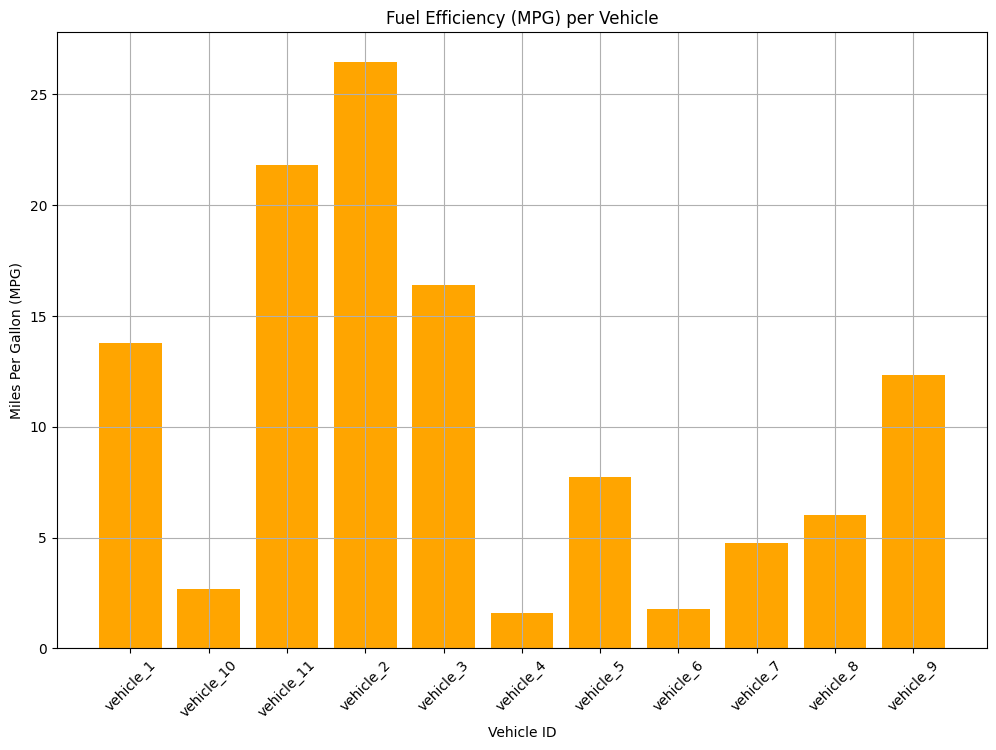

In [234]:
plt.figure(figsize=(12, 8))
plt.bar(vehicle_summary['vehicle_id'], vehicle_summary['mpg'], color='orange')
plt.title('Fuel Efficiency (MPG) per Vehicle')
plt.xlabel('Vehicle ID')
plt.ylabel('Miles Per Gallon (MPG)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# Analysis of Distribution Plots

The visualizations provide insightful information about the distribution of key variables in the dataset.

## 1. Speed Distribution
The speed distribution plot is highly skewed towards lower speeds, with the vast majority of data points clustered around zero. This could indicate that vehicles often operate at very low speeds or are idle frequently. The distribution also shows a very low frequency of higher speeds, with only a few instances reaching up to 140 mph. This skewness suggests that extreme speeds are rare in the dataset.

## 2. Odometer Distribution
The odometer readings exhibit a more typical distribution, with a significant number of vehicles having traveled between 0 and 15,000 miles. The frequency gradually decreases as the mileage increases, indicating fewer vehicles with higher mileage. This pattern suggests that the majority of the vehicles are relatively new or have been in operation for shorter periods.

## 3. Fuel Level Distribution
The fuel level distribution shows a fairly uniform spread across different levels, with a noticeable peak at the full tank mark (100%). This indicates that vehicles often operate with varying amounts of fuel, but there is a tendency for them to have full tanks, likely due to frequent refueling. The smoothness of the distribution also implies consistent recording of fuel levels without major gaps or irregularities.

These distributions provide a good overview of the dataset, highlighting typical operational patterns of the vehicles and pointing out areas, like speed, where data is heavily skewed towards specific values.


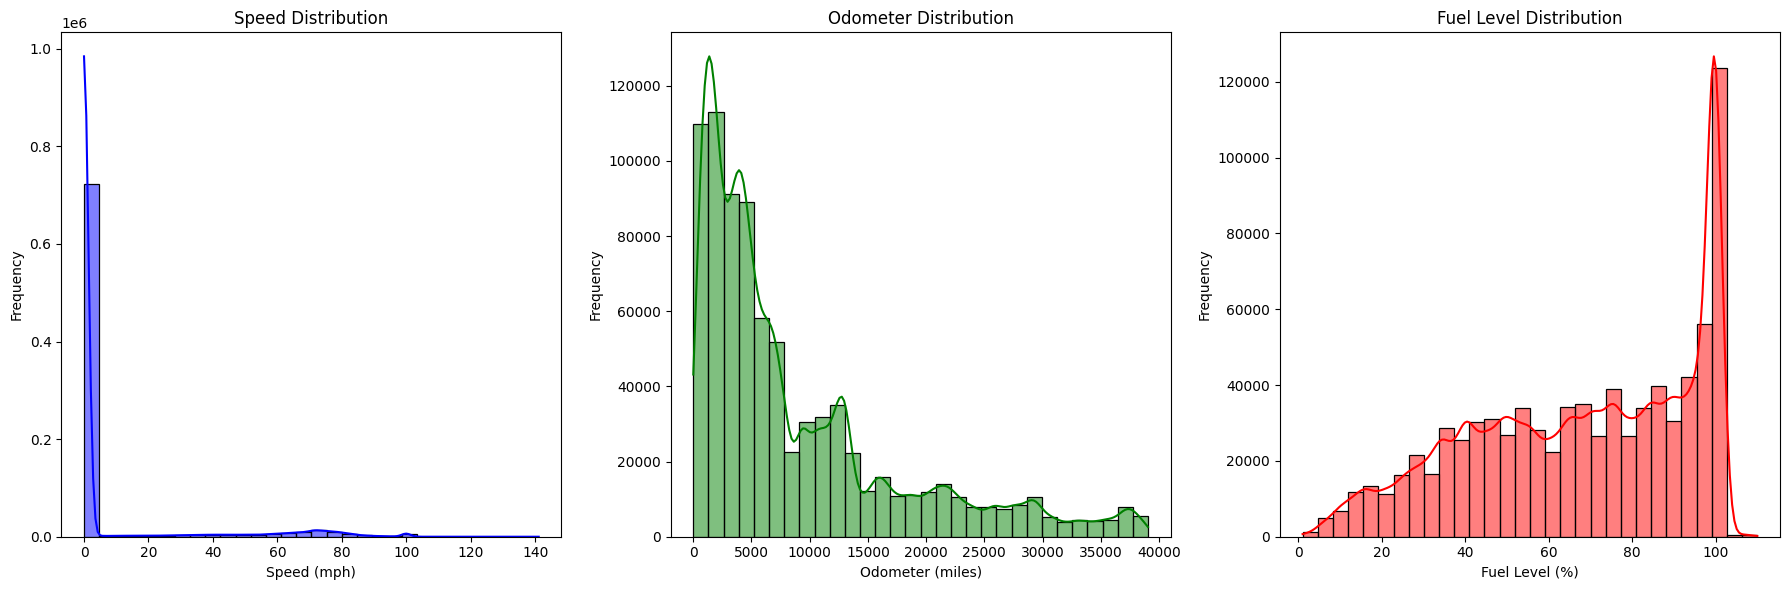

In [235]:
# Plotting distributions of speed, odometer, and fuel level
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.histplot(combined_telemetry['speed'], bins=30, kde=True, color='blue')
plt.title('Speed Distribution')
plt.xlabel('Speed (mph)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sns.histplot(combined_telemetry['odometer'], bins=30, kde=True, color='green')
plt.title('Odometer Distribution')
plt.xlabel('Odometer (miles)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
sns.histplot(combined_telemetry['fuel_level'], bins=30, kde=True, color='red')
plt.title('Fuel Level Distribution')
plt.xlabel('Fuel Level (%)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
